/Users/kangcifong/anaconda/lib/python3.5/site-packages/numpy/polynomial/polynomial.py:1383: RankWarning: The fit may be poorly conditioned
  warnings.warn(msg, pu.RankWarning)


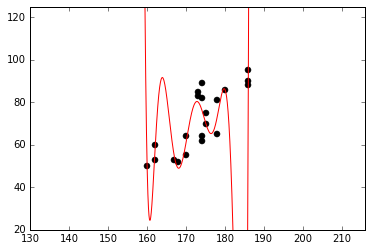

In [4]:
import numpy as np
import numpy.linalg as la
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd

%matplotlib inline

dt = np.dtype([('w', np.float), ('h', np.float), ('g', np.str_, 1)])
data = np.loadtxt('data/whData.dat', dtype=dt, comments='#', delimiter=None)

# read height, weight and gender information into 1D arrays
wgt = np.array([d[0] for d in data], dtype='float64')
hgt = np.array([d[1] for d in data], dtype='float64')
gs = np.array([d[2] for d in data])

np.set_printoptions(precision=30)

xmin = hgt.min() - 30
xmax = hgt.max() + 30
ymin = wgt.min() - 30
ymax = wgt.max() + 30

def plot_data_and_fit(h, w, x, y):
    plt.plot(h, w, 'ko', x, y, 'r-')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()

def plot_data_and_fitAll(h, w, x, y, xmin, xmax, ymin, ymax):
    plt.plot(h, w, 'ko', x, y, 'r-')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()
    
def trsf(x):
    return x / 100


n = 10
x = np.linspace(xmin, xmax, 10000)

# method 1:
# regression using ployfit
c = poly.polyfit(hgt, wgt, n)
y = poly.polyval(x, c)
plot_data_and_fit(hgt, wgt, x, y)

In [ ]:
# method 2:
# regression using the Vandermonde matrix and pinv
X = poly.polyvander(hgt, n)
c = np.dot(la.pinv(X), wgt)
y = np.dot(poly.polyvander(x, n), c)
plot_data_and_fit(hgt, wgt, x, y)

In [ ]:
# method 3:
# regression using the Vandermonde matrix and lstsq
X = poly.polyvander(hgt, n)
c = la.lstsq(X, wgt)[0]
y = np.dot(poly.polyvander(x, n), c)
plot_data_and_fit(hgt, wgt, x, y)

In [ ]:
# method 4:
# regression on transformed data using the Vandermonde
# matrix and either pinv or lstsq
X = poly.polyvander(trsf(hgt), n)
c = np.dot(la.pinv(X), wgt)
y = np.dot(poly.polyvander(trsf(x),n), c)
plot_data_and_fit(hgt, wgt, x, y)

## See how it changes with different divisor

In [5]:
def trsfA(x, divisor):
    return x / divisor

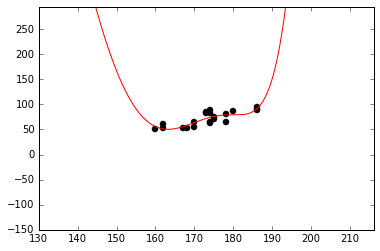

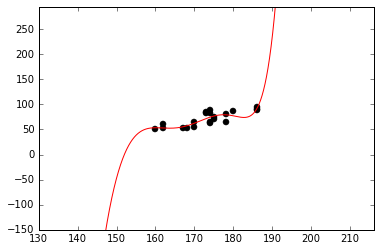

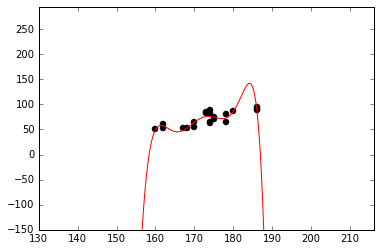

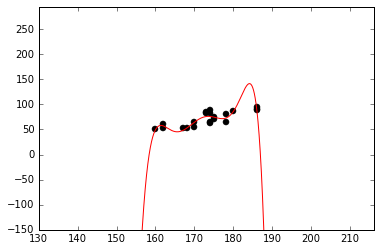

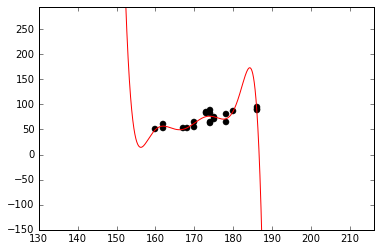

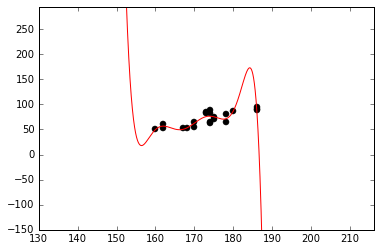

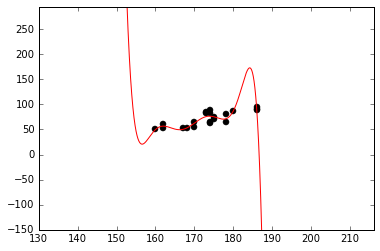

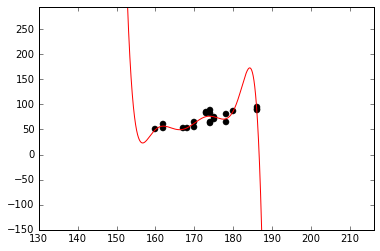

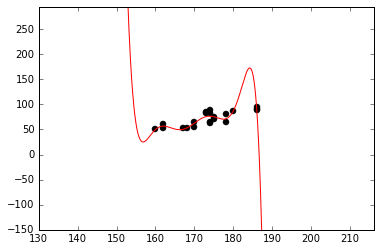

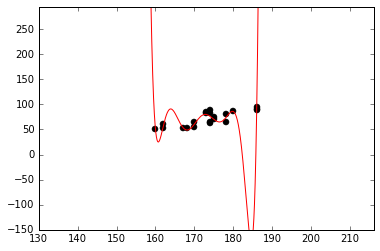

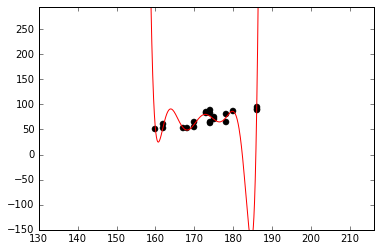

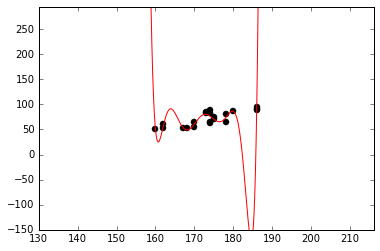

In [7]:
for i in range(1,120,10):
    X = poly.polyvander(trsfA(hgt,i), n)
    c = np.dot(la.pinv(X), wgt)
    y = np.dot(poly.polyvander(trsfA(x,i),n), c)
    plot_data_and_fit(hgt, wgt, x, y)

## The fitting dimention went up as the divisor goes up,
- The value in given data is 3 digit decimal, 
- divisor = 100 make the value to 1 digit

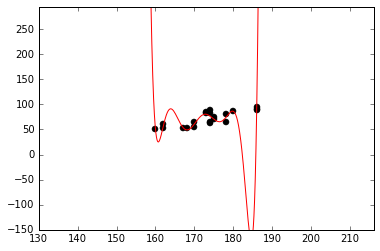

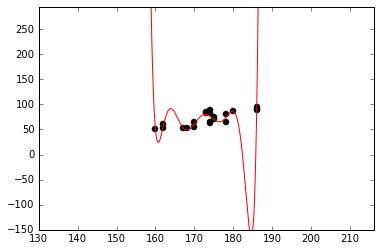

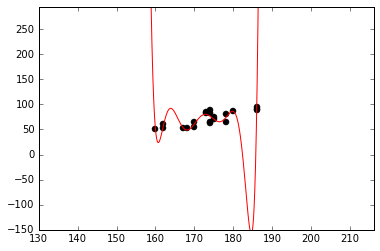

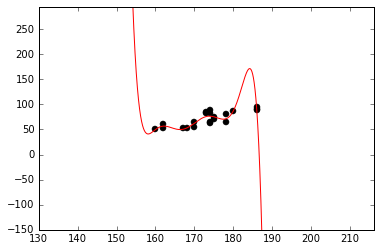

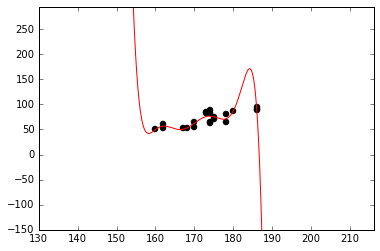

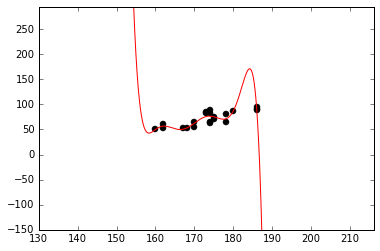

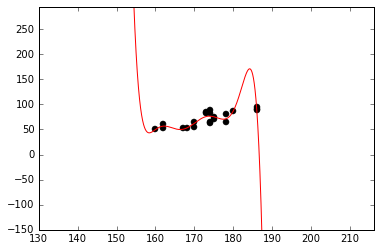

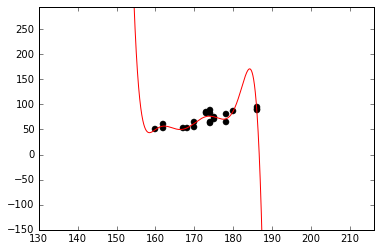

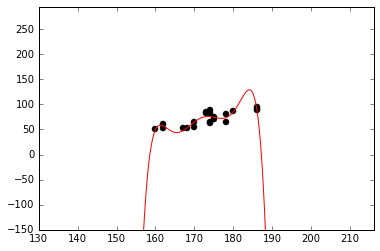

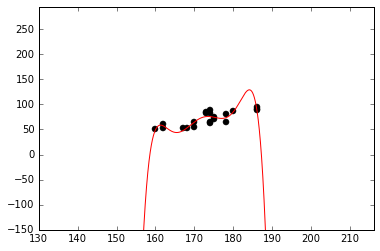

In [8]:
for i in range(100,1100,100):
    X = poly.polyvander(trsfA(hgt,i), n)
    c = np.dot(la.pinv(X), wgt)
    y = np.dot(poly.polyvander(trsfA(x,i),n), c)
    plot_data_and_fit(hgt, wgt, x, y)

## The fitting dimention drops as the divisor goes furthur up
- divisor = 1000, make the value one digit below 0
- So it could be a overflow problem

## Floating point issue in Python
- By Python Documentation
- 0.1(decimal) is presented as 
- 0.00011001100110011001100110011001100110011001100110011010(Binary)
- Print (0.1)
- 0.1000000000000000055511151231257827021181583404541015625
- https://docs.python.org/2/tutorial/floatingpoint.html

In [9]:
print(np.finfo(np.float32))
print(np.finfo(np.float64))

Machine parameters for float32
---------------------------------------------------------------
precision=  6   resolution= 1.0000000e-06
machep=   -23   eps=        1.1920929e-07
negep =   -24   epsneg=     5.9604645e-08
minexp=  -126   tiny=       1.1754944e-38
maxexp=   128   max=        3.4028235e+38
nexp  =     8   min=        -max
---------------------------------------------------------------

Machine parameters for float64
---------------------------------------------------------------
precision= 15   resolution= 1.0000000000000001e-15
machep=   -52   eps=        2.2204460492503131e-16
negep =   -53   epsneg=     1.1102230246251565e-16
minexp= -1022   tiny=       2.2250738585072014e-308
maxexp=  1024   max=        1.7976931348623157e+308
nexp  =    11   min=        -max
---------------------------------------------------------------



## Look in to numpy.linalg.pinv
- numpy.linalg.pinv(a, rcond=1e-15)
- rcond is the precision of float 64, which linalg supports
- we found this code inside 

In [ ]:
# a, wrap = _makearray(a)
# _assertNoEmpty2d(a)
# a = a.conjugate()
# u, s, vt = svd(a, 0)
# m = u.shape[0]
# n = vt.shape[1]
# cutoff = rcond*maximum.reduce(s)
# for i in range(min(n, m)): 
#     if s[i] > cutoff:           #Suspicious part, set value to zero
#         s[i] = 1./s[i]
#     else:
#         s[i] = 0.; 
# res = dot(transpose(vt), multiply(s[:, newaxis], transpose(u)))
# return wrap(res)

## Test this part
- See how many cutsin different divisor

In [25]:
from numpy.core import umath as um

def trsfA(x, divisor):
    return x / divisor

def countPinvCutoff(a):
    
    rcond=1e-15
    a = um.conjugate(a)
    u,s,vt = la.svd(a,0)
    sNoCut = np.copy(s)
    m = u.shape[0]
    n = vt.shape[1]
    cutoff = rcond*um.maximum.reduce(s)
    cutCount=0

    for i in range(min(n, m)):
        if s[i] < cutoff:
            cutCount+=1
        
    return cutCount, cutoff

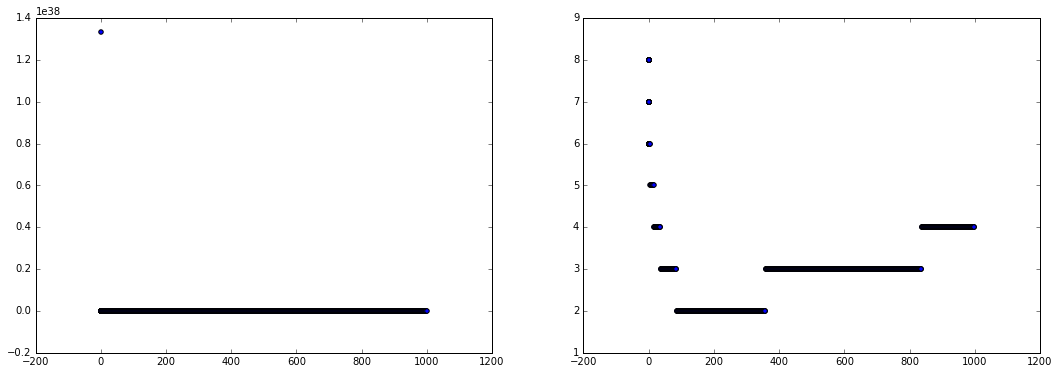

In [93]:
count = []
cutoffValue = []
inteNI = np.arange(0.001,1,0.001)
intePI = np.arange(1,1000,1)
divisor = np.append(inteNI, intePI)
for i in divisor:
    X = poly.polyvander(trsfA(hgt,i), n)
    cutCount, cutoff = countPinvCutoff(X)
    list.append(count, cutCount)
    list.append(cutoffValue, cutoff)

fig = plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.scatter(divisor, cutoffValue)
plt.subplot(122)
plt.scatter(divisor, count)

## Discussion
- 1.Ther trend mathes the degeneration of fitting function that 
-   the lower the cut off, the higher remaining dimension we have
- 2.We would have at least 2 cutoffs in all divisor

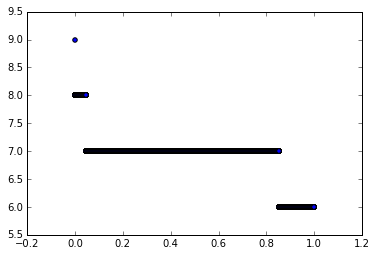

In [16]:
count = []
for i in np.arange(0.0001,1,0.0001):
    X = poly.polyvander(trsfA(hgt,i), n)
    list.append(count, countPinvCutoff(X))
plt.scatter(np.arange(0.0001,1,0.0001), count)

In [107]:
from numpy.core import umath as um

def trsfA(x, divisor):
    return x / divisor

def pinv(a):
    
    cntCO=0
    cntTol=0
    rcond=1e-15
    a = um.conjugate(a)
    u,s,vt = la.svd(a,0)
    sNoCut = np.copy(s)
    m = u.shape[0]
    n = vt.shape[1]
    cutoff = rcond*um.maximum.reduce(s)
    tolerence = max(m,n)*um.maximum.reduce(s)*rcond
#     print("calculated cutoff",cutoff)
#     print("calculated tolerence",tolerence)
    for i in range(min(n, m)):
        if s[i] < cutoff:
            cntCO+=1
        if s[i] > tolerence:
            s[i] = 1./s[i]
            sNoCut[i]=1./sNoCut[i]
        else:
            cntTol+=1
            s[i] = 0.
            sNoCut[i]=1./sNoCut[i]
        
       
    res = np.dot(vt.T,um.multiply(s[:,np.newaxis], u.T))
    resNoCut = np.dot(vt.T,um.multiply(sNoCut[:,np.newaxis], u.T))
    
    return res, resNoCut, tolerence, cutoff, cntTol, cntCO
#     resNoCut = np.dot(vt.T,um.multiply(sNoCut[:,np.newaxis], u.T))

In [114]:
def demoPic(divisor):
    xmin = hgt.min() - 10
    xmax = hgt.max() + 10
    ymin = wgt.min() - 200
    ymax = wgt.max() + 200
    X = poly.polyvander(trsfA(hgt,divisor), n)
    inv, invN, tol, co, cntTol, cntCO = pinv(X)
    
    print("divisor: %4.4f, tolerence: %4.16f, tolCount:%2d, cutoff:%4.16f, CoCount:%2d" % (divisor, tol, cntTol, co, cntCO))
    
    cL = np.dot(la.pinv(X), wgt)
    yL = np.dot(poly.polyvander(trsfA(x,divisor),n), cL)
    
    c = np.dot(inv, wgt)
    y = np.dot(poly.polyvander(trsfA(x,divisor),n), c)
    
    fig = plt.figure(figsize=(18, 6))
    plt.subplot(131)
    plt.title("Use own defined threshold (tolerence)")
    plt.plot(hgt, wgt, 'ko',x, y, 'r-')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.subplot(132)
    plt.title("numpy.linalg.pinv theshold (cutoff)")
    plt.plot(hgt, wgt, 'ko',x, yL, 'r-')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    cN = np.dot(invN, wgt)
    yN = np.dot(poly.polyvander(trsfA(x,divisor),n), cN)
    plt.subplot(133)
    plt.title("Without Cutoff")
    plt.plot(hgt, wgt, 'ko',x, yN, 'r-')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()

## Plot some divisors on 3 variants
- Compare with the tolerence = epslon * max(m,n) * maximum(s)
- linalg.inv cutoff = epslon * maximum(s)
- No cut off

divisor: 0.0100, tolerence: 279582202827253860620707037184.0000000000000000, tolCount: 8, cutoff:13313438229869231143982727168.0000000000000000, CoCount: 8


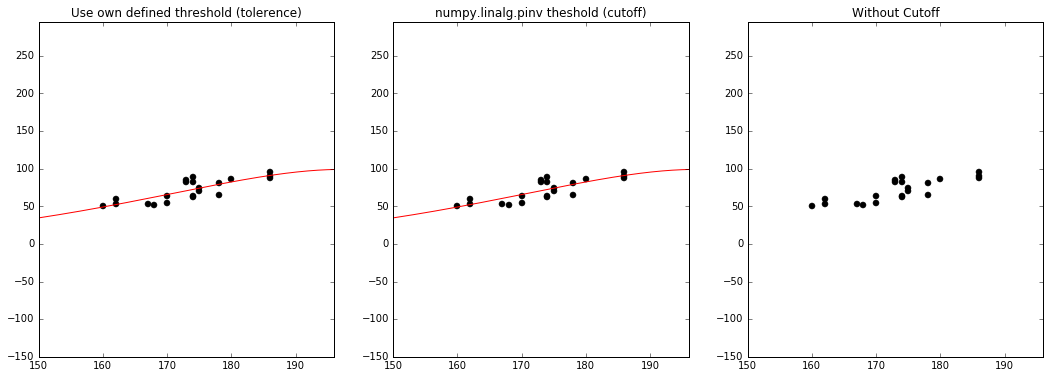

divisor: 0.0500, tolerence: 28629218642458107183104.0000000000000000, tolCount: 8, cutoff:1363296125831338524672.0000000000000000, CoCount: 7


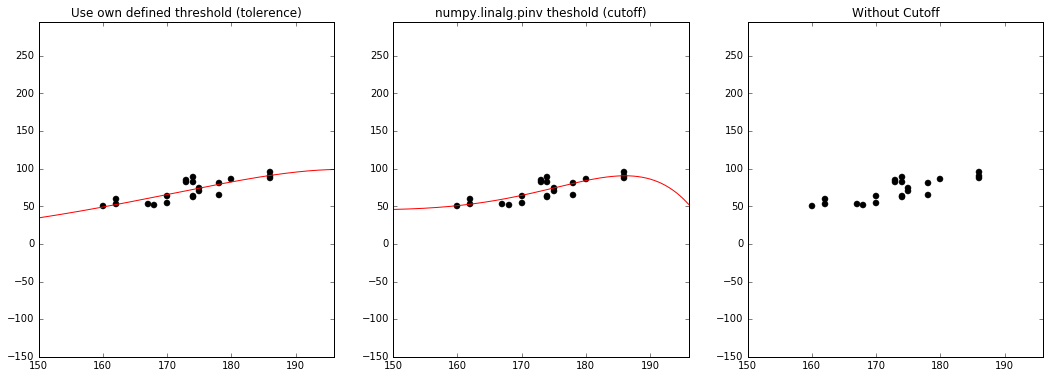

divisor: 0.1000, tolerence: 27958224604901580800.0000000000000000, tolCount: 8, cutoff:1331344028804837376.0000000000000000, CoCount: 7


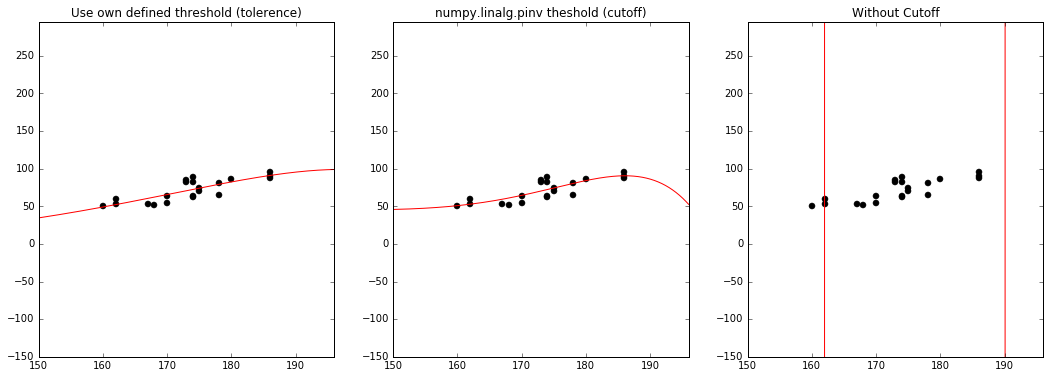

divisor: 0.5000, tolerence: 2862932929080.0292968750000000, tolCount: 7, cutoff:136330139480.0014038085937500, CoCount: 7


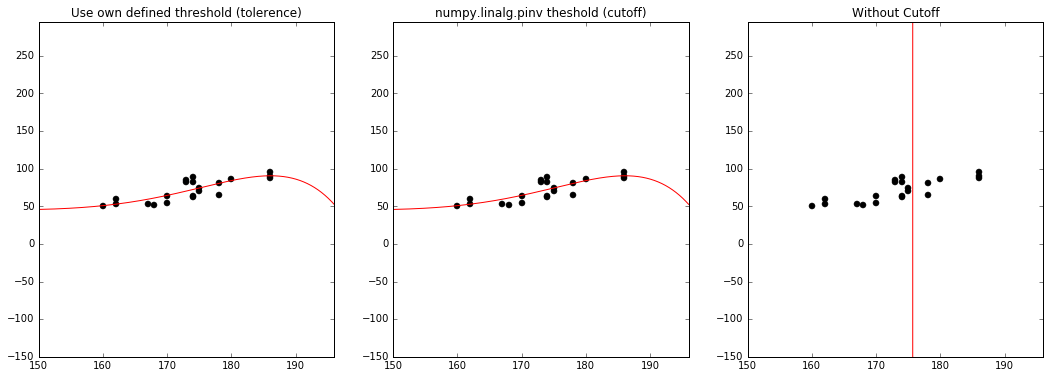

divisor: 1.0000, tolerence: 2795865683.2700839042663574, tolCount: 7, cutoff:133136461.1080992370843887, CoCount: 6


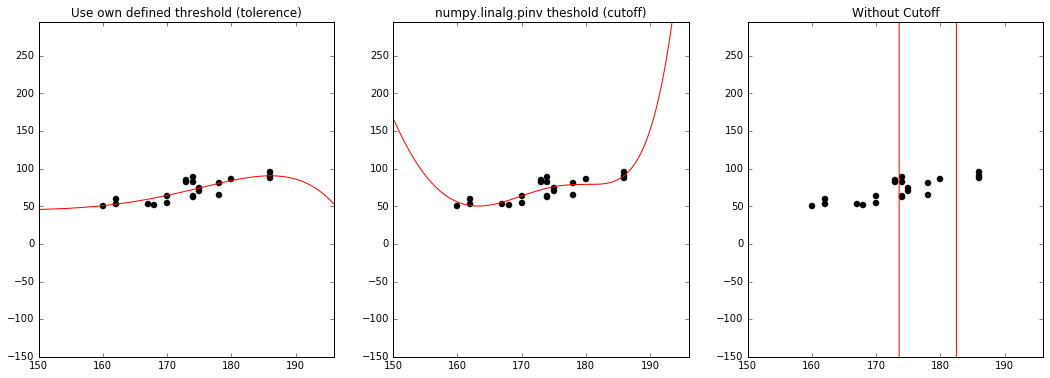

divisor: 5.0000, tolerence: 286.4040064468964601, tolCount: 6, cutoff:13.6382860212807824, CoCount: 5


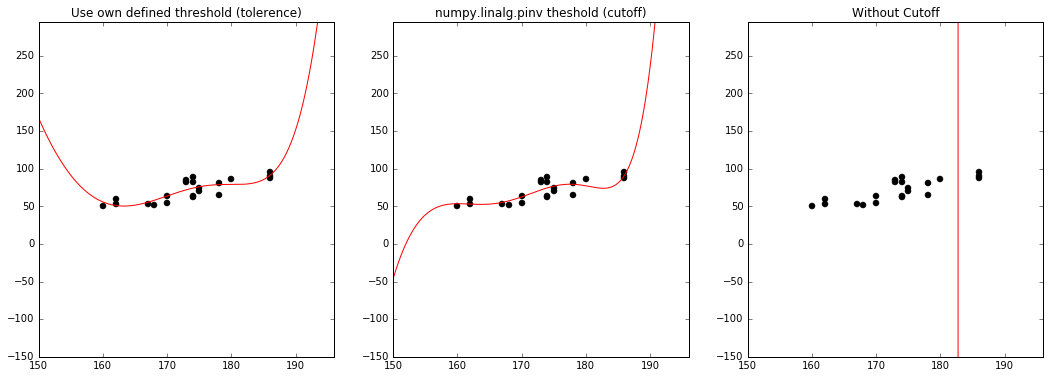

divisor: 10.0000, tolerence: 0.2800198168618731, tolCount: 5, cutoff:0.0133342769934225, CoCount: 5


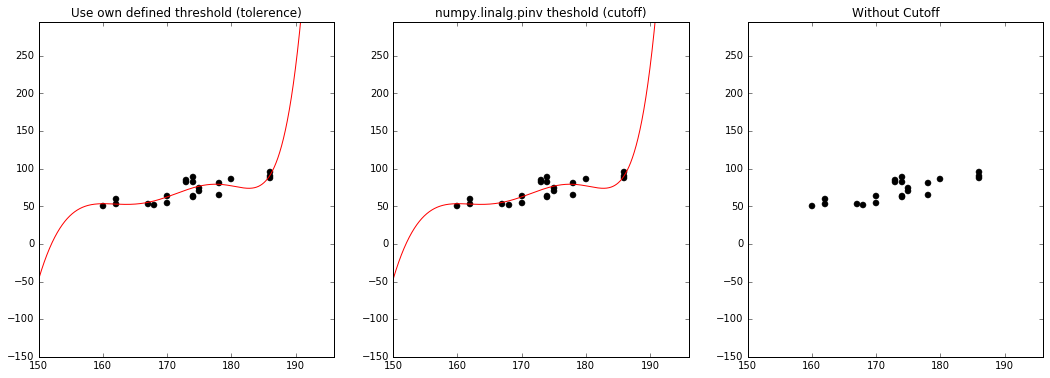

divisor: 50.0000, tolerence: 0.0000000298173451, tolCount: 4, cutoff:0.0000000014198736, CoCount: 3


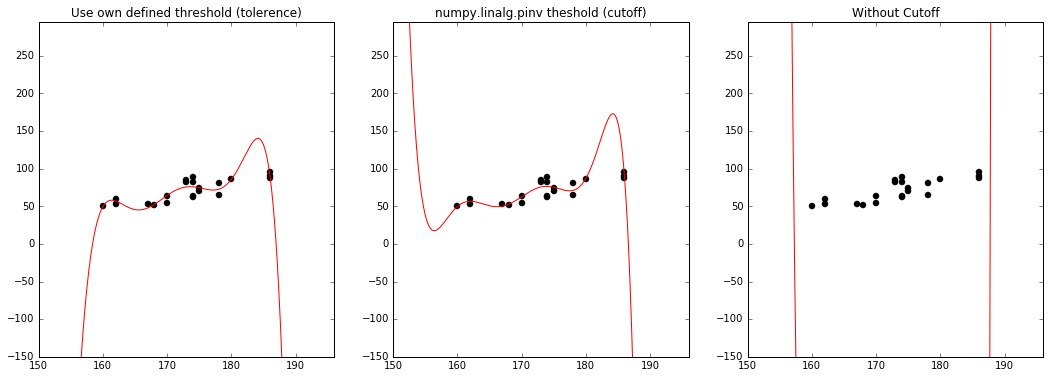

divisor: 100.0000, tolerence: 0.0000000000337292, tolCount: 3, cutoff:0.0000000000016062, CoCount: 2


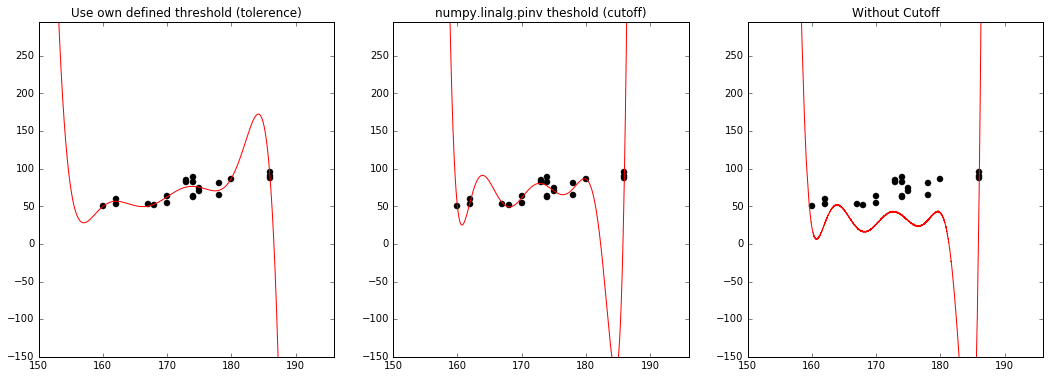

divisor: 500.0000, tolerence: 0.0000000000001026, tolCount: 3, cutoff:0.0000000000000049, CoCount: 3


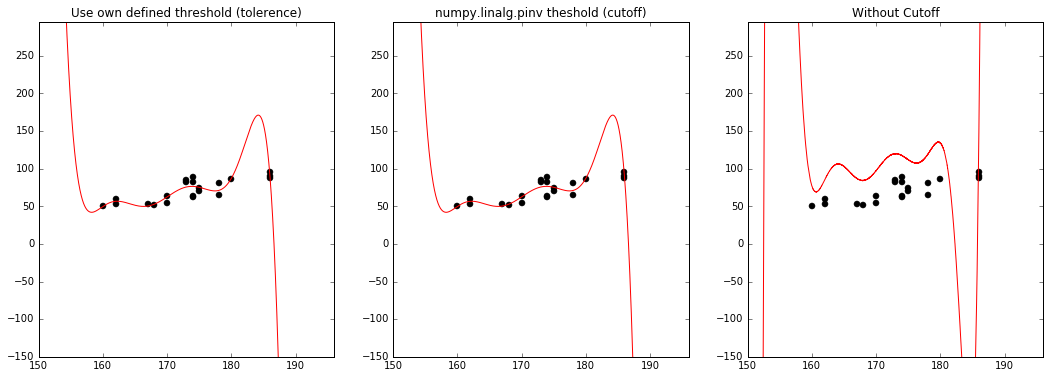

divisor: 1000.0000, tolerence: 0.0000000000000977, tolCount: 4, cutoff:0.0000000000000047, CoCount: 4


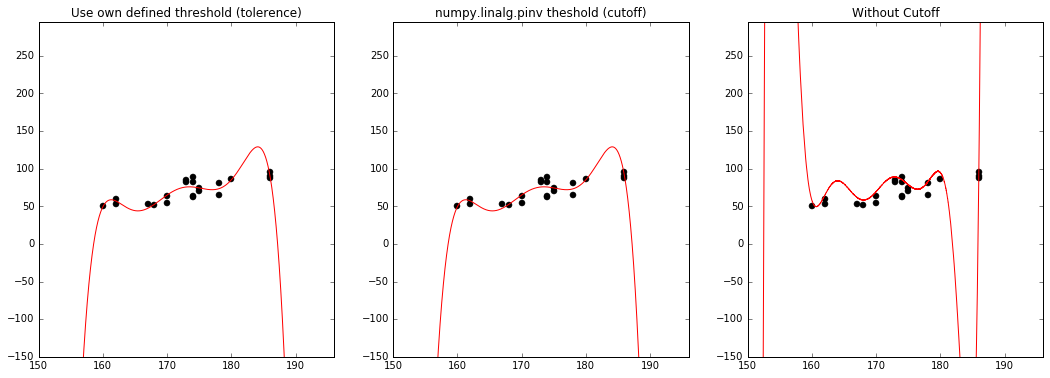

In [119]:
index = [0.01,0.05,0.1,0.5, 1,5, 10, 50, 100, 500, 1000]
for i in index:
    demoPic(i)